### Importing the packages

In [2]:
import argparse
import numpy as np
import os
import pandas as pd
from gwtrigfind import find_trigger_files
from gwpy.table import EventTable
from gwpy.segments import DataQualityDict
from gwpy.timeseries import TimeSeries
import datetime
from gwpy.time import tconvert
from gwpy.time import from_gps
from gwpy.time import to_gps
from gwpy.segments import Segment
from datetime import timedelta
from itertools import islice
from scipy.signal import correlate
import matplotlib.pyplot as plt
from gwpy.table import Table
import time
import h5py
from gwpy.segments import SegmentList
from gwpy.timeseries import TimeSeriesDict
from gwdetchar import scattering
from gwpy.segments import DataQualityFlag

In [4]:
import seaborn as sns
sns.set_style('whitegrid')
#plt.style.use('fivethirtyeight')

In [5]:
### this file contains the functions used in this notebook
import functions

### Scattering in O3a

In [6]:
### This dataframe contains triggers by gspy with snr between 8 and 10000 and confidence above 0.8, between Apr 1 and Sep 30 2019.
dfo3a = pd.read_csv('files/gspyo3aprsep.csv')

#### Data cleaning (removing duplicates, sorting by gpstime)

In [7]:
dfo3a = functions.dataframe_clean(dfo3a,'time',snr=8,conf=0.8)

In [8]:
dfo3a.describe()

,time,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,Q-value
count,1.144100e+04,11441.000000,11441.000000,1.144100e+04,11441.000000,11441.000000,11441.000000,11441.0,11441.0,11441.000000,11441.000000
mean,1.244333e+09,30.433728,26.926185,1.383167e-21,2938.875372,2.607778,5840.388424,0.0,0.0,0.960500,31.404823
std,4.548093e+06,37.114947,112.058212,5.929181e-21,1491.522981,2.648459,2987.273183,0.0,0.0,0.050895,16.037496
min,1.238176e+09,10.169000,8.000000,3.090000e-23,16.697000,0.125000,2.111870,0.0,0.0,0.800000,5.657000
25%,1.241467e+09,21.340000,9.006000,1.110000e-22,2628.303000,1.250000,5204.281738,0.0,0.0,0.941000,11.314000
50%,1.243437e+09,28.623000,10.601000,1.850000e-22,3819.860000,1.660000,7600.426270,0.0,0.0,0.985000,45.255000
75%,1.246678e+09,35.795000,28.799000,2.790000e-21,3981.154000,3.111000,7931.567383,0.0,0.0,0.998000,45.255000
max,1.253830e+09,1978.692000,7797.312000,4.150000e-19,3995.891000,39.250000,7946.482910,0.0,0.0,1.000000,45.255000


Text(0.5, 0, 'log10(SNR)')

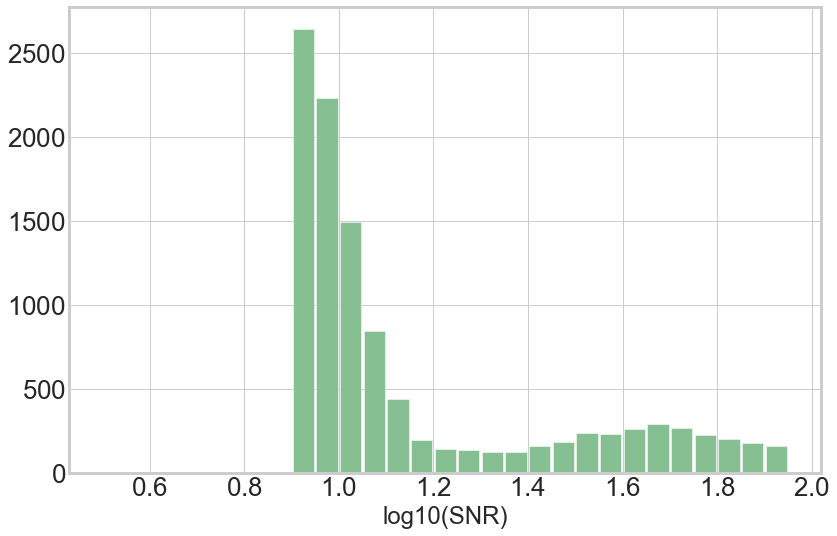

In [9]:
plt.figure(figsize=(12,8))
np.log10(dfo3a['snr']).hist(bins=np.arange(.5, 2, 0.05),xlabelsize=26,ylabelsize=26,color='#86bf91',rwidth=0.9)
#plt.title('Distribution of Log scaled SNR for total scattering in O3.',fontsize=18)
plt.xlabel('log10(SNR)',fontsize=24)

Text(0.5, 0, 'Seconds')

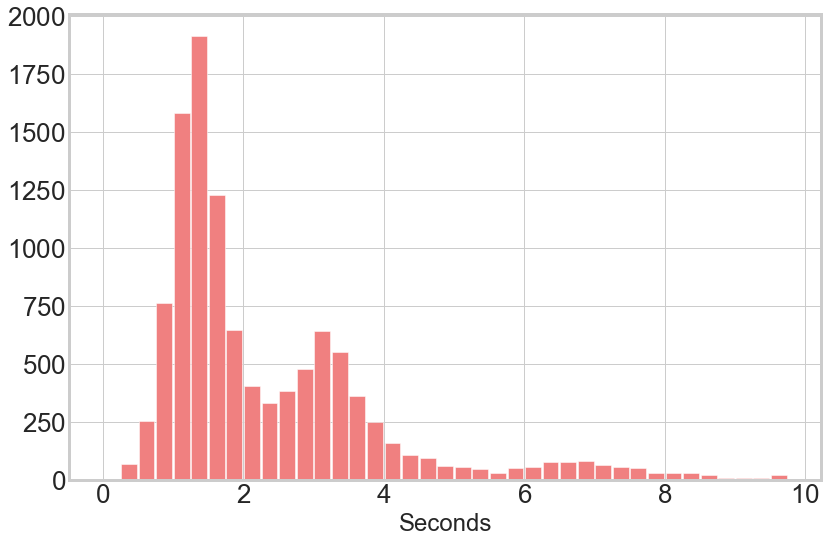

In [10]:
plt.figure(figsize=(12,8))
dfo3a['duration'].hist(bins=np.arange(0,10,0.25),xlabelsize=26,ylabelsize=26,rwidth=0.9,color='lightcoral')
#plt.title('Distribution of duration of total scattering in O3.',fontsize=18)
#plt.yscale('log')
plt.xlabel('Seconds',fontsize=24)

In [11]:
dfslow = dfo3a[dfo3a['snr']>=15].reset_index(drop=True)
dffast = dfo3a[dfo3a['snr']<15].reset_index(drop=True)

### Transmons as slow scattering veto

#### The file Xtransmonsmerged1.csv contains all the darm triggers caught by X end transmon blrms during O3a. The darm triggers are filtered by snr above 15 and lower than 200 and peakfreq between 10 and 60 Hz. The darmblrms are constructed after whitening the timeseries (4,2), bandpassing (4,10) and taking rms (1). The threshold for the blrms segments is 2 sigma above the mean of the whitnend blrms. All this can be verified by looking at the code transnmono3.py.

In [12]:
dfxto3a = pd.read_csv('files/Xtransmonsmerged1.csv')

#### We can find the number of triggers vetoed by X end transmons that match with Slow scattering by gravityspy

In [13]:
def round_time(a):
    return round(a,1)

In [14]:
#### Round the gpstime
dfxto3a['time'] = round_time(dfxto3a['time'])
dfslow['time'] = round_time(dfslow['time'])

In [15]:
match = [] #### triggers in dfxto3a (vetoed by transmons) that match with those in dfslow (caught by Gspy)
for i in dfslow['time']:
    for j in dfxto3a['time']:
        if abs(i-j)<0.1:
            match.append(j)
            break
match = list(set(match))
print(len(match))
print(len(dfxto3a))

2729
3864


In [16]:
print('{0} % of the triggers vetoed by X end transmons match slow scattering identified by Gravitspy.'.format(round(100*len(match)/len(dfxto3a))))

71 % of the triggers vetoed by X end transmons match slow scattering identified by Gravitspy.


In [17]:
#### These are the triggers caught by transmons that are not caught by GravitySpy.
notmatch = [i for i in dfxto3a['time'] if i not in match]

In [18]:
### These are the triggers caught by GravitySpy but not found by Transmons.
notmatchgspy = [i for i in dfslow['time'] if i not in match]

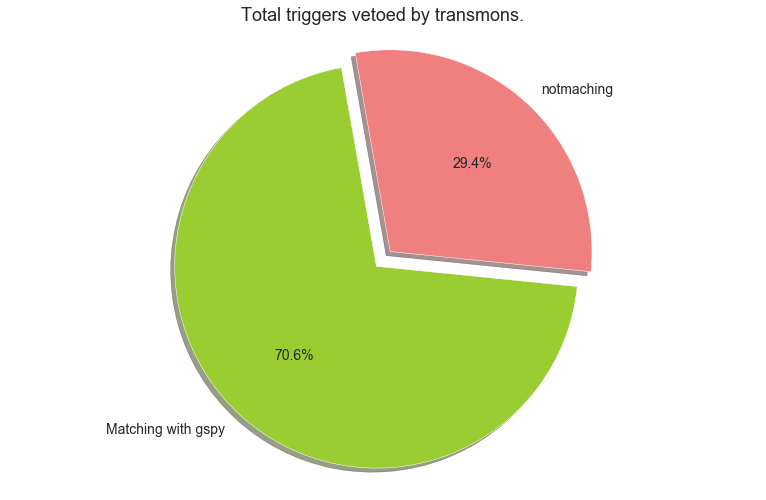

In [19]:
plt.figure(figsize=(12,8))
sizes = [len(match),len(notmatch)]
colors = ['yellowgreen', 'lightcoral']
explode = (0, 0.1)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=['Matching with gspy','notmaching'], colors=colors,
autopct='%1.1f%%',shadow=True, startangle=100,textprops={'fontsize': 14})

plt.axis('equal')
plt.title('Total triggers vetoed by transmons.',fontsize=18)
plt.show()

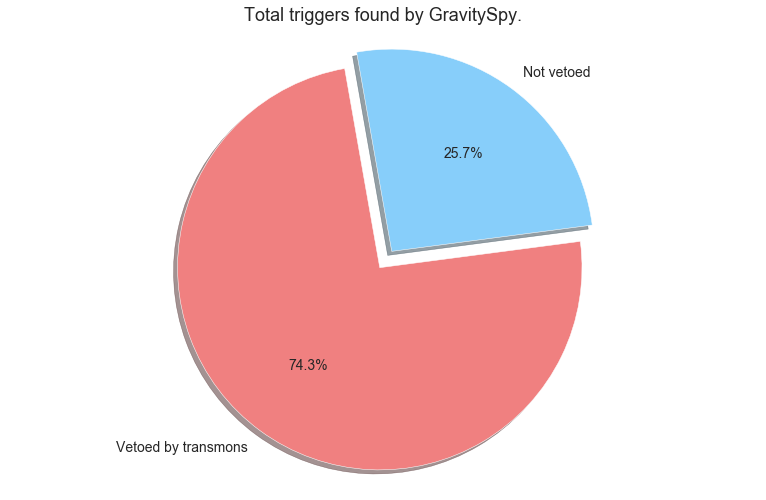

In [21]:
plt.figure(figsize=(12,8))
sizes = [len(match),len(notmatchgspy)]
colors = ['lightcoral', 'lightskyblue']
explode = (0, 0.1)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=['Vetoed by transmons','Not vetoed'], colors=colors,
autopct='%1.1f%%',shadow=True, startangle=100,textprops={'fontsize': 14})

plt.axis('equal')
plt.title('Total triggers found by GravitySpy.',fontsize=18)
plt.show()

### OSEMS and Transmons comparison

#### Here we compare the Efficiency over deadtime of OSEM's in catching slow scattering with that of Transmons for three days in O3a, April 13, May 13 and June 25. For each of these days, I am taking segments with high ground motion. The function trigsinosems looks at all the OSEM segments during the given time interval and finds coincidence with h(t) triggers with SNR between 15 and 200 and Peak Frequency between 10 and 60 Hz. The function trigsinsegs2 on the other hand, find coincidence between these triggers and blrms above a given threshold of X end photodiode timeseries. Each function returns the value of efficiency over deadtime. Efficiency is the percentage of triggers caught while deadtime is the total duration of the segments used to catch these triggers.

#### OSEM's

In [13]:
functions.trigsinosems(1239148818,1239148818+11*3600,'2019-04-13')

/home/siddharth.soni/Scattering_Project/functions.py:221: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  a.append(f['segments'][i]['active'].value)


Efficiency over deadtime for 2019-04-13 is 3.46


3.46

In [14]:
functions.trigsinosems(1241740818,1241740818+21*3600,'2019-05-13')

/home/siddharth.soni/Scattering_Project/functions.py:221: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  a.append(f['segments'][i]['active'].value)


Efficiency over deadtime for 2019-05-13 is 7.07


7.07

In [15]:
functions.trigsinosems(1245456018,1245456018+9.5*3600,'2019-06-25')

/home/siddharth.soni/Scattering_Project/functions.py:221: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  a.append(f['segments'][i]['active'].value)


Efficiency over deadtime for 2019-06-25 is 15.9


15.9

#### Transmon blrms

In [4]:
functions.trigsinsegs2(to_gps('2019-04-13'),to_gps('2019-04-13 11:00:00'),'files/gspyo3aprsep.csv',2)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/gwpy/timeseries/core.py:1153: NDSWarning: Low level daq error occured [26]: Requested data is on tape
  io_nds2.NDSWarning)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/gwpy/timeseries/core.py:1153: NDSWarning: Low level daq error occured [26]: Requested data is on tape
  io_nds2.NDSWarning)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/gwpy/timeseries/core.py:1153: NDSWarning: Low level daq error occured [26]: Requested data is on tape
  io_nds2.NDSWarning)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


20.904761904761905

In [6]:
functions.trigsinsegs2(to_gps('2019-05-13'),to_gps('2019-05-13 21:00:00'),'files/gspyo3aprsep.csv',2)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37/lib/python3.7/site-packages/gwpy/timeseries/core.py:1153: NDSWarning: Low level daq error occured [26]: Requested data is on tape
  io_nds2.NDSWarning)


27.89895470383275

In [5]:
functions.trigsinsegs2(to_gps('2019-06-25'),to_gps('2019-06-25 09:30:00'),'files/gspyo3aprsep.csv',2)

42.36094674556213

#### Now we can compare the Efficiency over deadtime of OSEM's with that of Transmons for April 13, May 13 and June 25.

In [22]:
eodosems = [3.46,7.07,15.9]
eodtrans = [20.90,27.89,42.36] # this was calculated by finding out the coincidence of scattering with transmon blrms

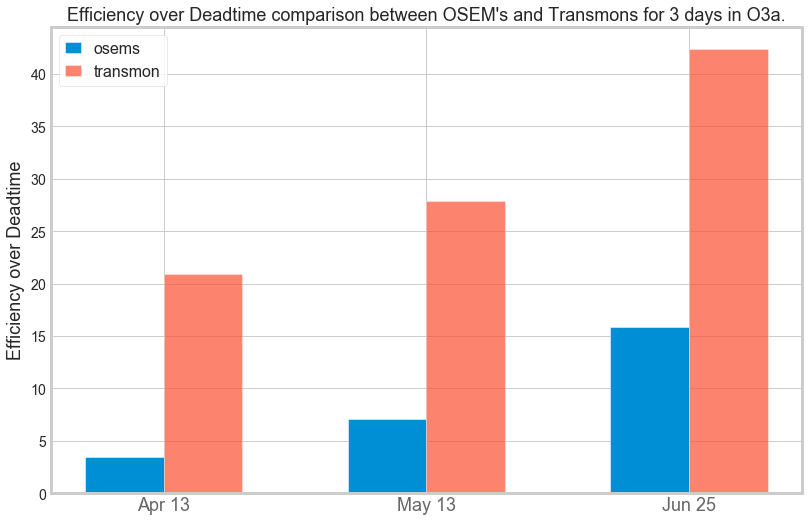

In [23]:
plt.figure(figsize=(12,8))
x = np.arange(3)
ax1 = plt.subplot(1,1,1)
w = 0.3

plt.xticks(x + w /2, ["Apr 13","May 13","Jun 25"],alpha=0.7,size=18)
pop =ax1.bar(x, eodosems ,width=w, align='center')
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
#ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
gdp =ax1.bar(x + w, eodtrans, width=w,align='center',alpha=0.7)
#Set the Y axis label as GDP.
plt.ylabel('Efficiency over Deadtime',fontsize=18)
#To set the legend on the plot we have used plt.legend()
plt.legend(['osems', 'transmon'],fontsize=16)
#To show the plot finally we have used plt.show().
plt.title("Efficiency over Deadtime comparison between OSEM's and Transmons for 3 days in O3a.",fontsize=18)
plt.show()

### GravitySpy scattering and X end PD noise correlation

In [24]:
dfo3a = functions.dataframe_clean(dfo3a,'time',snr=10,conf=0.95)

In [25]:
### X end PD triggers for first three months
cachextrb = find_trigger_files('L1:ASC-X_TR_B_NSUM_OUT_DQ','omicron',to_gps('Apr-01-2019'),to_gps('July-01-2019'),ext='h5')
dfxtrbaprmay = EventTable.read(cachextrb, format='hdf5', path='triggers', columns=['time','frequency','snr']).filter('snr>8','frequency<20')

In [29]:
dfo3at = Table.from_pandas(dfo3a)
tend = dfxtrbaprmay['time'][-1]
tstart = dfxtrbaprmay['time'][0]

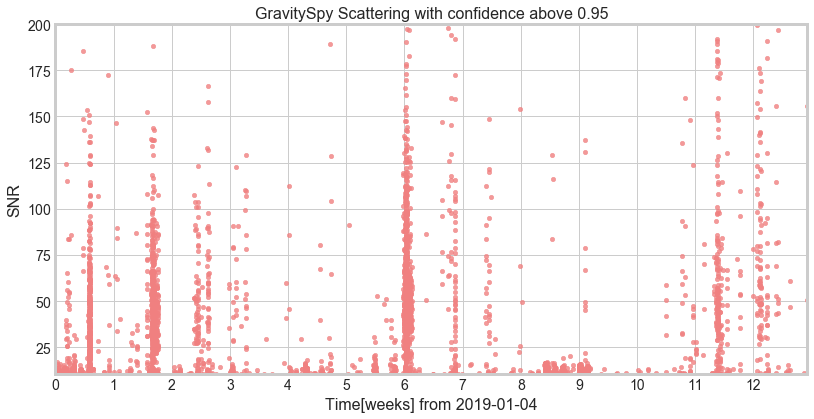

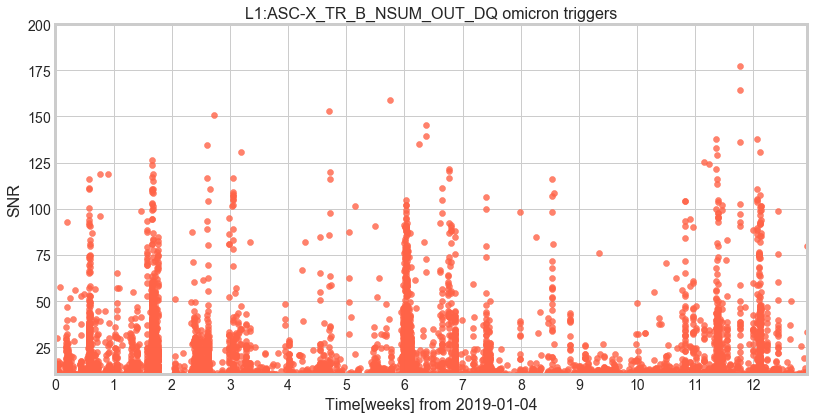

In [33]:
dfo3a.plot(x='time',y='snr',figsize=(12,6),c='lightcoral',alpha=0.8,kind='scatter')
plt.ylim(10,200)
plt.xlim(tstart,tend)
plt.xticks(np.arange(tstart,tend,24*7*3600),np.arange(0,13,1),fontsize=14)
plt.title("GravitySpy Scattering with confidence above 0.95",fontsize=16)
plt.xlabel('Time[weeks] from 2019-01-04',fontsize=16)
plt.ylabel('SNR',fontsize=16)
plt.show()
dfxtrbaprmay.plot(x='time',y='snr',c='tomato',alpha=0.8)
plt.ylim(10,200)
plt.xlim(tstart,tend)
plt.ylabel('SNR',fontsize=16)
plt.xticks(np.arange(tstart,tend,24*7*3600),np.arange(0,13,1),fontsize=14)
plt.title("L1:ASC-X_TR_B_NSUM_OUT_DQ omicron triggers",fontsize=16)
plt.xlabel('Time[weeks] from 2019-01-04',fontsize=16)
plt.show()

